In [1]:
import os,time,sys,datetime,math
import numpy as np
import pandas as pd

root = '/Users/Data/UCI/Confemm/wine+quality/'
filename = 'winequality-white.csv'

path = os.path.join(root, filename)
df = pd.read_csv(path,sep=';')
N_d = df.shape[0]
print(N_d)

print(df.columns)
print(df.isna().sum())
print(df.head())

4898
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32       

In [2]:
from sklearn.model_selection import train_test_split

Train = df.sample(frac=0.9)
Test = df.drop(Train.index)

# X = df.values[:,:-1].astype(np.float32)
# print(X.shape)
# y = df.values[:,-1].astype(np.int64)
# print(y.shape)

# X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0)
X_train = Train.values[:,:-1].astype(np.float32)
X_test = Test.values[:,:-1].astype(np.float32)
Y_train = Train.values[:,-1].astype(np.int64)
Y_test = Test.values[:,-1].astype(np.int64)

print(X_train.shape)
print(Y_test.shape)

(4408, 11)
(490,)


In [6]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

cls = GradientBoostingClassifier(random_state=0)
cls.fit(X_train, Y_train)
score = cls.score(X_test, Y_test)
print(score)

0.6653061224489796


(array([  2.,   0.,  14.,   0., 156.,   0., 197.,   0.,  98.,  23.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <BarContainer object of 10 artists>)

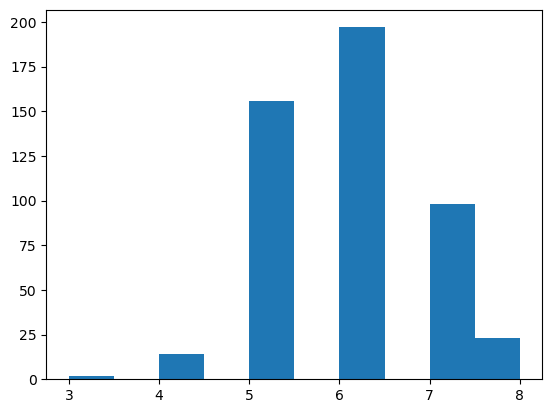

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
# ax.fill_between(I, 0, probs)
ax.hist(Y_test)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

class Classifier(nn.Module):
    def __init__(self, infea:int=11, hidden:int=50, out:int=10, *args, **kwargs):
        super(Classifier, self).__init__(*args, **kwargs)
        self.infea = infea
        self.hidden = hidden
        self.out = out
        self.encoder = nn.Sequential(
            nn.Linear(infea, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden*2),
            nn.BatchNorm1d(hidden*2),
            nn.ReLU(),
            nn.Linear(hidden*2, hidden*4),
            nn.BatchNorm1d(hidden*4),
            nn.ReLU(),
            nn.Linear(hidden*4, hidden*4),
            nn.BatchNorm1d(hidden*4),
            nn.ReLU(),
            nn.Linear(hidden*4, hidden*4),
            nn.BatchNorm1d(hidden*4),
            nn.ReLU(),
        )
        self.final = nn.Linear(hidden*4, out)

    def forward(self, x: Tensor):
        h = self.encoder(x)
        logits = self.final(h)
        return logits

In [5]:
import copy
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from typing import Any, Optional, OrderedDict, List
from collections import defaultdict

def train(dataset: Optional[dict], model: nn.Module, optimizer: Optional[Any], scheduler: Optional[Any],
          epoch: int=100, batch_size: int=32, device: str='cpu'):
    trainloss = defaultdict(list)
    testloss = defaultdict(list)

    X_train, X_test, y_train, y_test = dataset['train_x'], dataset['test_x'], dataset['train_y'], dataset['test_y']
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epoch):
        print("epoch: " + str(epoch) + '===================================================')
        n_train = X_train.shape[0]
        n_test = X_test.shape[0]
        if epoch == 0:
            print(f'train length: {n_train}, test length: {n_test}')

        I = list(range(0, n_train))
        
        running_loss = 0.0
        running_test_loss = 0.0
        running_corrects = 0
        running_test_corrects = 0

        model.train()
        for i_batch in range(n_train // batch_size):
            if i_batch < (n_train // batch_size - 1):
                I_b = I[i_batch * batch_size:(i_batch+1) * batch_size]
            else:
                I_b = I[i_batch * batch_size:]
            x_batch = X_train[I_b, :]
            y_batch = y_train[I_b]

            x_batch = torch.from_numpy(x_batch).to(torch.float32).to(device)
            y_batch = torch.from_numpy(y_batch).to(torch.int64).to(device)

            # print(y_batch)

            with torch.set_grad_enabled(True):
                logits = model(x_batch)
                loss = torch.nn.functional.cross_entropy(logits, y_batch)
                _, preds = torch.max(logits, 1)
                corrects = torch.sum(preds == y_batch.data)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                trainloss['loss'].append(loss.item())
                running_loss += loss.item() * x_batch.size(0)
                running_corrects +=  corrects.item()
                acc = corrects.item()*1.0/x_batch.size(0)
                trainloss['running acc'].append(acc)

            if i_batch > 0 and i_batch % 50 == 0:
                print(f'ibatch: {i_batch}, train loss: {loss}, train acc: {acc}.')
        
        epoch_loss = running_loss / n_train
        epoch_acc = running_corrects * 1.0 / n_train
        
        trainloss['epoch'].append(epoch_loss)
        trainloss['epoch_acc'].append(epoch_acc)

        I = list(range(0, n_test))
        model.eval()
        for i_batch in range(n_test // batch_size):
            if i_batch < (n_test // batch_size - 1):
                I_b = I[i_batch * batch_size:(i_batch+1) * batch_size]
            else:
                I_b = I[i_batch * batch_size:]
            x_batch = X_test[I_b, :]
            y_batch = y_test[I_b]

            x_batch = torch.from_numpy(x_batch).to(torch.float32).to(device)
            y_batch = torch.from_numpy(y_batch).to(torch.int64).to(device)

            with torch.set_grad_enabled(False):
                logits = model(x_batch)
                loss = torch.nn.functional.cross_entropy(logits, y_batch)
                _, preds = torch.max(logits, 1)
                corrects = torch.sum(preds == y_batch.data)
                
                testloss['loss'].append(loss.item())
                running_test_loss += loss.item()*x_batch.size(0)
                running_test_corrects += corrects.item()
                acc = corrects.item() * 1.0 / x_batch.size(0)
                testloss['acc'].append(acc)
                
        epoch_test_loss = running_test_loss / n_test
        epoch_acc = running_test_corrects * 1.0 / n_test
                
        testloss['epoch'].append(epoch_test_loss)
        testloss['epoch_acc'].append(epoch_acc)

        print(f'test loss: {epoch_test_loss}, test acc: {epoch_acc}.')

    time_elapsed = time.time() - since
    print(("Training complete in %sm %ss" % (time_elapsed // 60, time_elapsed % 60)))

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    #         'scheduler_state_dict': scheduler.state_dict(),
        'trainloss': trainloss,
        'testloss': testloss,
        }, 'model_final')
    return model, trainloss, testloss



In [6]:
device = 'cpu'

datasets = dict()
datasets['train_x'] = X_train
datasets['test_x'] = X_test
datasets['train_y'] = Y_train
datasets['test_y'] = Y_test

model = Classifier().to(device)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

model, trainloss, valloss = train(dataset=datasets, model=model, optimizer=optimizer, 
                                  scheduler=scheduler, epoch=50, batch_size=32)

epoch: 0===================================================
train length: 4408, test length: 490
ibatch: 50, train loss: 1.2703289985656738, train acc: 0.53125.
ibatch: 100, train loss: 1.1926307678222656, train acc: 0.5.
test loss: 1.298386753335291, test acc: 0.4306122448979592.
epoch: 1===================================================
ibatch: 50, train loss: 1.132036566734314, train acc: 0.5.
ibatch: 100, train loss: 1.1367747783660889, train acc: 0.5625.
test loss: 1.170369038289907, test acc: 0.43673469387755104.
epoch: 2===================================================
ibatch: 50, train loss: 1.0174922943115234, train acc: 0.53125.
ibatch: 100, train loss: 1.1093828678131104, train acc: 0.5625.
test loss: 1.2348661729267665, test acc: 0.4530612244897959.
epoch: 3===================================================
ibatch: 50, train loss: 1.1464197635650635, train acc: 0.46875.
ibatch: 100, train loss: 1.126381516456604, train acc: 0.5625.
test loss: 1.166465316013414, test acc

tensor([[1.0000, 1.0000, 1.0000,  ..., 0.9457, 0.9965, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 0.9185, 0.9933, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 0.5085, 0.7429, 0.9926],
        ...,
        [0.9998, 0.9998, 0.9998,  ..., 0.5619, 0.8783, 0.9966],
        [0.9999, 0.9999, 0.9999,  ..., 0.9336, 0.9935, 0.9999],
        [1.0000, 1.0000, 1.0000,  ..., 0.9342, 0.9971, 1.0000]],
       grad_fn=<RsubBackward1>)
490


(array([ 33., 118.,  61.,  53.,  63.,  42.,  35.,  34.,  19.,  32.]),
 array([0.34076309, 0.40659387, 0.47242465, 0.53825543, 0.60408621,
        0.66991699, 0.73574777, 0.80157855, 0.86740932, 0.9332401 ,
        0.99907088]),
 <BarContainer object of 10 artists>)

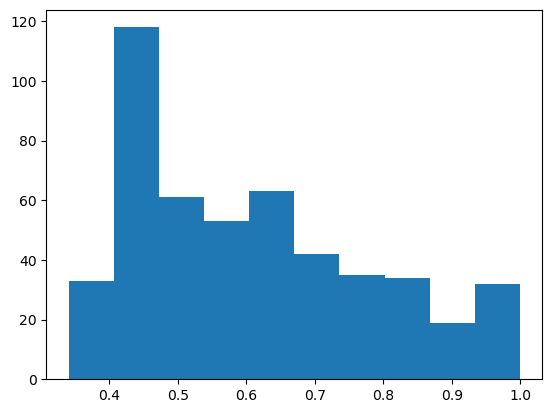

In [7]:
x_test = torch.from_numpy(X_test).to(torch.float32).to(device)
y_test = torch.from_numpy(Y_test).to(torch.int64).to(device)

x_train = torch.from_numpy(X_train).to(torch.float32).to(device)
y_train = torch.from_numpy(Y_train).to(torch.int64).to(device)

sfs = 1-model(x_test).softmax(dim=1)
print(sfs)
scores = []
for i in range(sfs.shape[0]):
    scores.append(sfs[i][y_test[i]].item())

print(len(scores))
fig, ax = plt.subplots(1, 1)
# ax.fill_between(I, 0, probs)
ax.hist(scores, density=False)

In [8]:
alpha = 0.1
n = len(scores)
qalpha = np.ceil((n+1)*(1-alpha))/n
print(qalpha)
qhat = torch.quantile(torch.tensor(np.array(scores)), torch.tensor(qalpha))
print(qhat)

0.9020408163265307
tensor(0.8708, dtype=torch.float64)


tensor([1.0106e-04, 1.0042e-04, 1.0118e-04, 1.8834e-03, 8.3839e-03, 1.3394e-01,
        5.8068e-01, 2.4335e-01, 3.1167e-02, 3.0091e-04],
       grad_fn=<SelectBackward0>)
tensor(3)
[3, 2, 3, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 3, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2,

(array([3.000e+00, 0.000e+00, 0.000e+00, 2.794e+03, 0.000e+00, 0.000e+00,
        1.609e+03, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

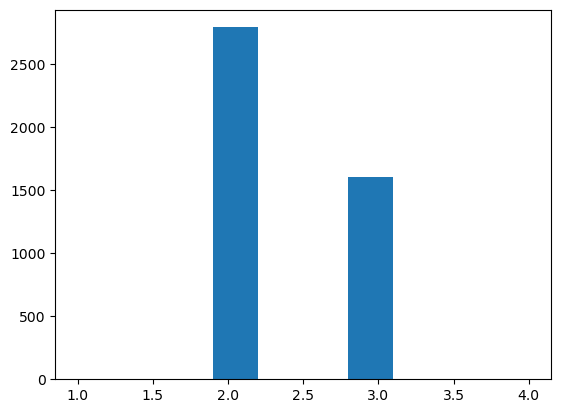

In [9]:
x_train = torch.from_numpy(X_train).to(torch.float32).to(device)

sms = model(x_train).softmax(dim=1)
print(sms[0])
prediction_sets = (sms > (1-qhat))
print(torch.sum(prediction_sets[0]))
sets = []
for i in range(sms.shape[0]):
    sets.append(torch.sum(prediction_sets[i]).to(torch.int64).item())
print(sets)
fig, ax = plt.subplots(1, 1)
# ax.fill_between(I, 0, probs)
ax.hist(sets, density=False)

490
avg cov: 0.897040
avg cov: 0.892710


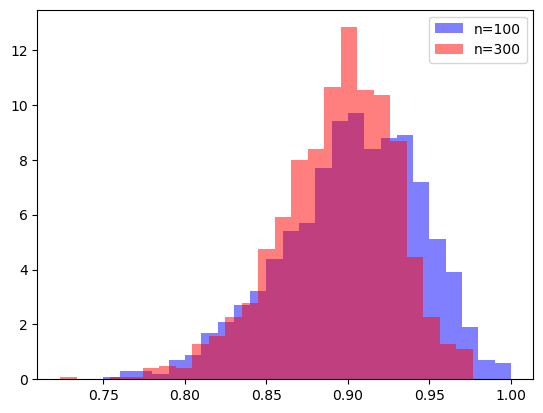

In [10]:
R = 1000
print(n)
alpha=0.1
scores_ = torch.tensor(scores)
coverages = torch.zeros((R,))
for r in range(R):
    scores__ = scores_[torch.randperm(490)]
    calib_scores, val_scores = (scores__[:100], scores__[390:])
    qalpha = np.ceil((n+1)*(1-alpha))/n
    qhat_ = torch.quantile(calib_scores, qalpha)
    coverages[r] = (val_scores <= qhat_).float().mean()
average_coverage = coverages.mean()
print('avg cov: %f' % average_coverage)

coverages2 = torch.zeros((R,))
for r in range(R):
    scores__ = scores_[torch.randperm(490)]
    calib_scores, val_scores = (scores__[:100], scores__[190:])
    # print(calib_scores.mean())
    qalpha = np.ceil((n+1)*(1-alpha))/n
    # print(qalpha)
    qhat_ = torch.quantile(calib_scores, qalpha)
    # print(qhat_)
    coverages2[r] = (val_scores <= qhat_).float().mean()
average_coverage = coverages2.mean()
print('avg cov: %f' % average_coverage)
plt.hist(coverages,bins=25,density=True,label='n=100', color='blue', alpha=0.5)
plt.hist(coverages2,bins=25,density=True,label='n=300', color='red', alpha=0.5)
plt.legend()

In [28]:
import os
import sys
sys.path.append(os.getcwd())
import pandas as pd
import numpy as np
from numpy import linalg as LA
import heapq

key_labels = {}
#
def as_string(desc):
    return ' and '.join(desc)

def satisfies_all(desc,df,N):
    d_str = as_string(desc)
    ind = df.eval(d_str)
    cover_desc = sum(ind)
    return (cover_desc / N > 0.0001 and cover_desc / N < 0.5)

class BoundedPriorityQueue:
    """
    Ensures uniqness
    Keeps a maximum size (throws away value with least quality)
    """

    def __init__(self, bound, df):
        self.values = []
        self.bound = bound
        self.entry_count = 0
        self.df = df

    def desc_intersect(self, desc1, coverage, desc2, c):
        ind_new = self.df.eval(as_string(desc1))
        ind_old = self.df.eval(as_string(desc2))
        if coverage*0.9 > c:
            return False
        if (ind_new & ind_old).sum() > c*0.8:
            return True
        return False

    def add(self, element, quality, coverage):
        if any((e == element for (_, _, e, _) in self.values)):
            return  # avoid duplicates

        # if any((self.desc_intersect(element, coverage, e, c) for (_,_,e,c) in self.values)):
        #     return        

        new_entry = (quality, self.entry_count, element, coverage)
        if (len(self.values) >= self.bound):
            temp=heapq.heappushpop(self.values, new_entry)
        else:
            heapq.heappush(self.values, new_entry)

        self.entry_count += 1

    def get_values(self):
        for (q, _, e, coverage) in sorted(self.values, reverse=True):
            yield (e, q, coverage)

    def out_vectors(self):
        return [q for (q, _, _, _) in sorted(self.values, reverse=True)]

    def show_contents(self):  # for debugging
        print("show_contents")
        for (q, entry_count, e, coverage) in self.values:
            # print(q, entry_count, e)
            print("quality: %f, entry: %d, element: %s, coverage: %f" % (q, entry_count, e, coverage))

#
class Queue:
    """
    Ensures uniqness
    """

    def __init__(self):
        self.items = []

    def is_empty(self):
        return self.items == []

    def enqueue(self, item):
        if item not in self.items:
            self.items.insert(0, item)

    def dequeue(self):
        return self.items.pop()

    def size(self):
        return len(self.items)

    def get_values(self):
        return self.items

    def add_all(self, iterable):
        for item in iterable:
            self.enqueue(item)

    def clear(self):
        self.items.clear()

In [34]:
def refine(desc, more):
    copy = desc[:]
    copy.append(more)
    return copy

def eta(seed,fs,df):
    for f in fs:
        column_data = df[f]
        if (df[f].dtype == 'float32'):
            min_val, max_val = min(column_data), max(column_data)
            for x in np.linspace(min_val, max_val, 10):
                candidate = "{} <= {value:.3f}".format(f, value=x)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} > {value:.3f}".format(f, value=x)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df[f].dtype == 'object'):
            uniq = column_data.dropna().unique()
            for i in uniq:
                candidate = "{} == '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} != '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df[f].dtype == 'int64'):
            min_val, max_val = min(column_data), max(column_data)
            for x in np.linspace(min_val, max_val, 10):
                candidate = "{} <= {}".format(f, np.floor(x))
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} > {}".format(f, np.floor(x))
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df[f].dtype == 'bool'):
            uniq = column_data.dropna().unique()
            for i in uniq:
                candidate = "{} == '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} != '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)                    
        else:
            assert False

def varphi_ent(d,n):
    return np.sqrt(-(d/n)*np.log2(d/n) - ((n-d)/n)*np.log2((n-d)/n))

def eval_quality(desc, model, df, mu_omega):
    d_str = as_string(desc)
    ind = df.eval(d_str)
    df_sd = df.loc[ind]
    
    x_sd = df_sd.values[:, :-1].astype(np.float32)
    x_sd = torch.from_numpy(x_sd).to(torch.float32).to(device)
    sms = model(x_sd).softmax(dim=1)
    predictions_sets = (sms > 1-qhat)
    sets_sd = []
    for i in range(sms.shape[0]):
        sets_sd.append(torch.sum(predictions_sets[i]).to(torch.int64).item())
    mu_sd = np.mean(sets_sd)
    # quality = mu_sd - mu_omega
    quality = mu_omega - mu_sd

    coverage = sum(ind) / df.shape[0]
    # ent = varphi_ent(sum(ind), df.shape[0])
    return quality, coverage

def EMM(df, fs, model, w, d, q, eta, satisfies_all, eval_quality):
    """
    w - width of beam
    d - num levels
    q - max results
    eta - a function that receives a description and returns all possible refinements
    satisfies_all - a function that receives a description and verifies wheather it satisfies some requirements as needed
    eval_quality - returns a quality for a given description. This should be comparable to qualities of other descriptions
    catch_all_description - the equivalent of True, or all, as that the whole dataset shall match
    """
    N = df.shape[0]

    x_omega = df.values[:, :-1].astype(np.float32)
    x_omega = torch.from_numpy(x_omega).to(torch.float32).to(device)
    sms = model(x_omega).softmax(dim=1)
    # print(sms[0])
    prediction_sets = (sms > (1-qhat))
    # print(torch.sum(prediction_sets[0]))
    sets_omega = []
    for i in range(sms.shape[0]):
        sets_omega.append(torch.sum(prediction_sets[i]).to(torch.int64).item())
    # print(sets)
    mu_omega = np.mean(sets_omega)
    print('mu omega: %f' % mu_omega)
                
    resultSet = BoundedPriorityQueue(q,df)
    candidateQueue = Queue()
    candidateQueue.enqueue([])
    for level in range(d):
        print("level : %d" % level)
        beam = BoundedPriorityQueue(w,df)
        for seed in candidateQueue.get_values():
            print("seed : %s" % str(seed))
            for desc in eta(seed, fs, df):
                if satisfies_all(desc,df,N):
                    quality, coverage = eval_quality(desc, model, df, mu_omega)
                    resultSet.add(desc, quality, coverage)
                    beam.add(desc, quality, coverage)
        beam.show_contents()
        #candidateQueue.clear()
        candidateQueue = Queue()
        candidateQueue.add_all(desc for (desc, _, _) in beam.get_values())
    return resultSet


In [15]:
Train['fixed_acidity'] = Train['fixed acidity'].astype(np.float32)
Train['volatile_acidity'] = Train['volatile acidity'].astype(np.float32)
Train['citric_acid'] = Train['citric acid'].astype(np.float32)
Train['residual_sugar'] = Train['residual sugar'].astype(np.float32)
Train['free_sulfur_dioxide'] = Train['free sulfur dioxide'].astype(np.float32)
Train['total_sulfur_dioxide'] = Train['total sulfur dioxide'].astype(np.float32)

In [35]:
features = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'chlorides', 'density', 'pH', 'sulphates', 'alcohol']

print("features: %s" % features)

# dff = df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']]
dff = Train[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']]
dff = dff.astype(np.float32)

EMM_res = EMM(df=dff, fs=features, model=model, w=20, d=2, q=10, eta=eta, satisfies_all=satisfies_all, eval_quality=eval_quality)

for (desc, quality, coverage) in EMM_res.get_values():
	print("{};{};{}\n".format(desc,quality,coverage))

features: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'chlorides', 'density', 'pH', 'sulphates', 'alcohol']
mu omega: 2.365245
level : 0
seed : []
show_contents
quality: 0.116534, entry: 39, element: ['free_sulfur_dioxide > 50.167'], coverage: 0.176044
quality: 0.165245, entry: 79, element: ['pH > 3.698'], coverage: 0.003403
quality: 0.132581, entry: 49, element: ['total_sulfur_dioxide > 167.889'], coverage: 0.248639
quality: 0.365245, entry: 32, element: ['residual_sugar > 36.822'], coverage: 0.000227
quality: 0.365245, entry: 27, element: ['residual_sugar <= 0.600'], coverage: 0.000454
quality: 0.136384, entry: 91, element: ['alcohol <= 9.378'], coverage: 0.201225
quality: 0.169593, entry: 50, element: ['total_sulfur_dioxide > 207.611'], coverage: 0.062613
quality: 0.365245, entry: 35, element: ['residual_sugar > 58.556'], coverage: 0.000227
quality: 0.365245, entry: 68, element: ['density > 1.022'], coverage: 

1


Text(0.5, 1.0, 'sulphates > 0.984 and total_sulfur_dioxide > 152.667\n score subgroup: 5.000, score whole data: 2.471')

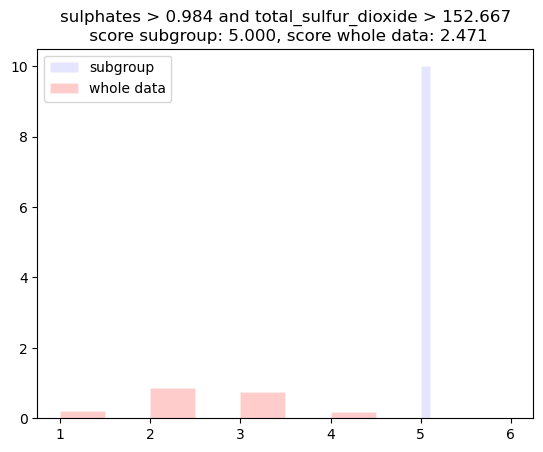

In [53]:
d_str = as_string(['sulphates > 0.984', 'total_sulfur_dioxide > 152.667'])
ind = dff.eval(d_str)
df_sd = dff.loc[ind]

x_sd = df_sd.values[:, :-1].astype(np.float32)
x_sd = torch.from_numpy(x_sd).to(torch.float32).to(device)
sms = model(x_sd).softmax(dim=1)
predictions_sets = (sms > 1-qhat)
sets_sd = []
for i in range(sms.shape[0]):
    sets_sd.append(torch.sum(predictions_sets[i]).to(torch.int64).item())
print(len(sets_sd))

x_omega = dff.values[:, :-1].astype(np.float32)
x_omega = torch.from_numpy(x_omega).to(torch.float32).to(device)
sms = model(x_omega).softmax(dim=1)
# print(sms[0])
prediction_sets = (sms > (1-qhat))
# print(torch.sum(prediction_sets[0]))
sets_omega = []
for i in range(sms.shape[0]):
    sets_omega.append(torch.sum(prediction_sets[i]).to(torch.int64).item())

fig, ax = plt.subplots(1, 1)
preds_sd = sets_sd
preds_wd = sets_omega
ax.hist(preds_sd, linewidth=0.5, edgecolor="white", color='b', alpha=0.1, label='subgroup', density=True)
ax.hist(preds_wd, linewidth=0.5, edgecolor="white", color='r', alpha=0.2, label='whole data', density=True)
plt.legend()

score_sd = np.mean(sets_sd)
score_all = np.mean(sets_omega)

ax.set_title(f'{d_str}\n score subgroup: {(score_sd):<0.3f}, score whole data: {(score_all):<0.3f}')

['free_sulfur_dioxide > 130.444', 'alcohol > 10.756'];1.3652450090744104;0.00022686025408348456

1
['free_sulfur_dioxide > 130.444', 'sulphates <= 0.507'];1.3652450090744104;0.00022686025408348456

1
['free_sulfur_dioxide > 130.444', 'sulphates <= 0.411'];1.3652450090744104;0.00022686025408348456

1
['free_sulfur_dioxide > 130.444', 'density <= 0.993'];1.3652450090744104;0.00022686025408348456

1
['free_sulfur_dioxide > 130.444', 'volatile_acidity > 0.420'];1.3652450090744104;0.00022686025408348456

1
1649


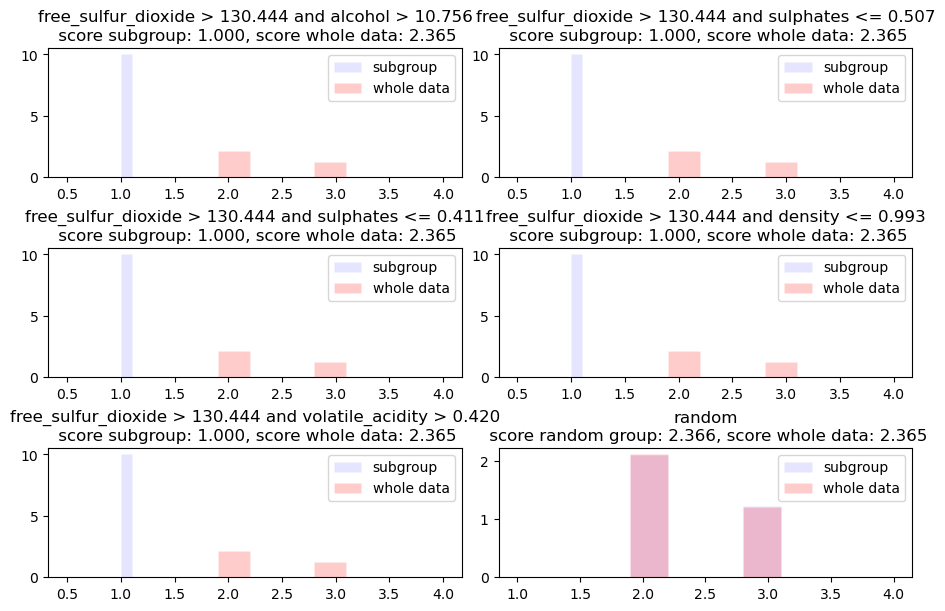

In [36]:
N_dff = dff.shape[0]

x_omega = dff.values[:, :-1].astype(np.float32)
x_omega = torch.from_numpy(x_omega).to(torch.float32).to(device)
sms = model(x_omega).softmax(dim=1)
# print(sms[0])
prediction_sets = (sms > (1-qhat))
# print(torch.sum(prediction_sets[0]))
sets_omega = []
for i in range(sms.shape[0]):
    sets_omega.append(torch.sum(prediction_sets[i]).to(torch.int64).item())

k = 0
q = 5
fig, axs = plt.subplots(3, 2, figsize=(9, 6), layout='constrained')

for (desc, quality, coverage) in EMM_res.get_values():
	print("{};{};{}\n".format(desc, quality, coverage))
	d_str = as_string(desc)
	ind = dff.eval(d_str)
	df_sd = dff.loc[ind]

	x_sd = df_sd.values[:, :-1].astype(np.float32)
	x_sd = torch.from_numpy(x_sd).to(torch.float32).to(device)
	sms = model(x_sd).softmax(dim=1)
	predictions_sets = (sms > 1-qhat)
	sets_sd = []
	for i in range(sms.shape[0]):
		sets_sd.append(torch.sum(predictions_sets[i]).to(torch.int64).item())
	print(len(sets_sd))

	ax = axs.flat[k]
	if ax is None:
		ax = plt.gca()

	preds_sd = sets_sd
	preds_wd = sets_omega
	ax.hist(preds_sd, linewidth=0.5, edgecolor="white", color='b', alpha=0.1, label='subgroup', density=True)
	ax.hist(preds_wd, linewidth=0.5, edgecolor="white", color='r', alpha=0.2, label='whole data', density=True)
	score_sd = np.mean(sets_sd)
	score_all = np.mean(sets_omega)
	ax.set_title(f'{d_str}\n score subgroup: {(score_sd):<0.3f}, score whole data: {(score_all):<0.3f}')
	ax.legend()
	k += 1
	if k == 5:
		break

inds_rand = np.random.permutation(N_dff)
flag = np.random.randint(np.int32(0.2*N_dff), np.int32(0.5*N_dff))
inds_rand = inds_rand[:flag]
inputs = dff.iloc[inds_rand]

x_rand = inputs.values[:, :-1].astype(np.float32)
x_rand = torch.from_numpy(x_rand).to(torch.float32).to(device)
sms = model(x_rand).softmax(dim=1)
predictions_sets = (sms > 1-qhat)
sets_rand = []
for i in range(sms.shape[0]):
	sets_rand.append(torch.sum(predictions_sets[i]).to(torch.int64).item())
print(len(sets_rand))
ax = axs.flat[k]
preds_sd = sets_rand
preds_wd = sets_omega
ax.hist(preds_sd, linewidth=0.5, edgecolor="white", color='b', alpha=0.1, label='subgroup', density=True)
ax.hist(preds_wd, linewidth=0.5, edgecolor="white", color='r', alpha=0.2, label='whole data', density=True)
score_sd = np.mean(sets_rand)
score_all = np.mean(sets_omega)
ax.set_title(f'{'random'}\n score random group: {(score_sd):<0.3f}, score whole data: {(score_all):<0.3f}')
ax.legend()

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, betabinom
from scipy.optimize import brentq
import itertools
import seaborn as sns

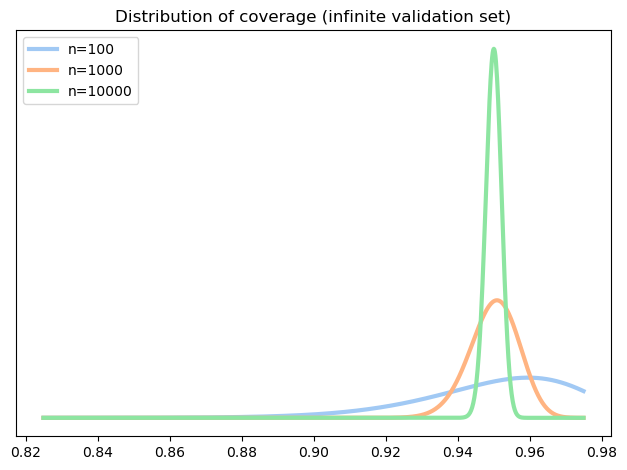

In [51]:
ns = [100, 1000, 10000]
alpha = 0.05

sns.set_palette('pastel')
plt.figure()
ax = plt.gca()

for i in range(len(ns)):
    n = ns[i]
    l = np.floor((n+1)*alpha)
    a = n + 1 - l
    b = l
    x = np.linspace(0.825, 0.975, 1000)
    rv = beta(a, b)
    ax.plot(x, rv.pdf(x), lw=3, label=f'n={n}')

plt.yticks([])
plt.legend()
plt.title('Distribution of coverage (infinite validation set)')
plt.tight_layout()